# Final Group Assignment
- Analyzing news articles to determine if they are fake or real, using a dataset from kaggle.

### 1. Analysis: Frame the problem and look at the big picture
2. Define the objective in business terms: Create a model capable of recognizing fake and real news.
3. How should you frame the problem (supervised/unsupervised etc.)?: Supervised learning, with binary labeling (1 for real, 0 for fake news) 
4. How should performance be measured?: Performance will be measured by the model accuracy, correctly classified vs. all.

In [40]:
#imports
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from gensim.models import Word2Vec

### 2. Get the data
Data were retrieved from Kaggle (link below). This data set consists of 2 csv files, one with the real and other with the real news. Both data sets have 'Title', 'Text', 'Subject' and 'Date' columns. 

https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

In the next step we labeled fake and real data, with 0 and 1 respectively and then merged them into 1 dataframe and shuffled them.

In [13]:
#Load & label fake news data
df_fake = pd.read_csv('Fake.csv')
df_fake['label'] = 0

In [14]:
#Load & label real news data
df_true = pd.read_csv('True.csv')
df_true['label'] = 1
#rename all 'politicsNews' to 'politics' in df_true
df_true['subject'] = df_true['subject'].replace('politicsNews', 'politics')

In [15]:
#print distinct subjects
print(df_fake['subject'].unique())
print(df_true['subject'].unique())

['News' 'politics' 'Government News' 'left-news' 'US_News' 'Middle-east']
['politics' 'worldnews']


In [17]:
#merge & shuffle data
df_news = pd.concat([df_fake, df_true]).sample(frac=1).reset_index(drop=True)
df_news.head()

,title,text,subject,date,label
0,OBAMA WILL GIVE AWAY FREE INTERNET (To Those H...,Don t turn off your paid internet service quit...,left-news,"Jul 16, 2015",0
1,U.S. Justice Department says anti-bias law doe...,"(In this July 27 story, corrects paragraph 7 ...",politics,"July 27, 2017",1
2,House will not reach healthcare deal before tw...,WASHINGTON (Reuters) - Deep divisions cut shor...,politics,"April 5, 2017",1
3,Muslim holds ancient key to Jesus tomb site in...,"JERUSALEM (Reuters) - As dark falls, Adeeb Jou...",worldnews,"November 30, 2017",1
4,UK foreign secretary says Hariri should return...,BEIRUT (Reuters) - British Foreign Secretary B...,worldnews,"November 12, 2017",1


# 3. Explore and visualise the data to gain insights

# Visualization

In [18]:
#group data by subject and label
df_news.groupby(['subject', 'label']).size()

subject          label
Government News  0         1570
Middle-east      0          778
News             0         9050
US_News          0          783
left-news        0         4459
politics         0         6841
                 1        11272
worldnews        1        10145
dtype: int64

[Text(0, 0, 'Fake'), Text(1, 0, 'Real')]

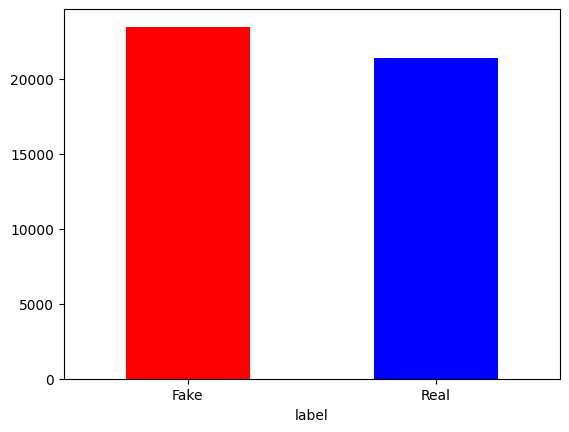

In [19]:
#fake vs real news
df_news.groupby(['label']).size().plot(kind='bar', color=['red', 'blue']).set_xticklabels(['Fake', 'Real'], rotation=0)

<Axes: xlabel='subject'>

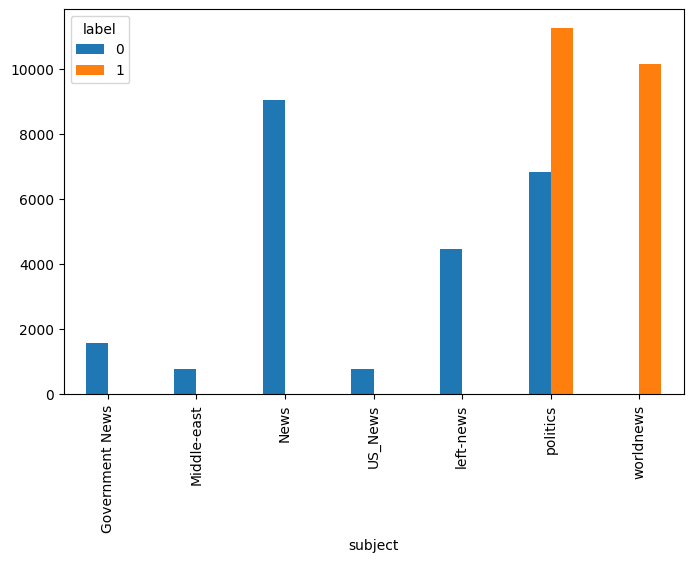

In [20]:
#number of articles per subject and label
df_news.groupby(['subject', 'label']).size().unstack().plot(kind='bar', stacked=False, figsize=(8, 5))

In [21]:
#print the full text of the first 5 articles of subject 'worldnews'
for i in range(5):
    print(df_news[(df_news['subject'] == 'worldnews') & (df_news['label'] == 1)]['text'].iloc[i])
    print('---------------------------------')

JERUSALEM (Reuters) - As dark falls, Adeeb Joudeh, a Muslim, makes his way through the stone alleyways of Jerusalem s walled Old City cradling the ancient key to one of Christianity s holiest sites. Centuries ago, the imposing iron key to the Church of the Holy Sepulchre, built where many Christians believe Jesus was crucified and buried, was entrusted to his family, one of Jerusalem s most prominent clans, says Joudeh. He dates the arrangement back to the time of Saladin, the Muslim conqueror who seized the holy city from the Crusaders in 1187.  Honestly, it s a great honor for a Muslim to hold the key to the Church of the Holy Sepulchre, which is the most important church in Christendom,  Joudeh, 53, said.     Another of the city s oldest Muslim families, the Nusseibehs, were entrusted with the duty of opening and closing the church doors, a task they perform to this day. It requires firm fingers: The key is 30 cm (12 inches) long and weighs 250 grams (0.5 pounds). Historians differ 

[Text(0, 0, 'Fake'), Text(1, 0, 'Real')]

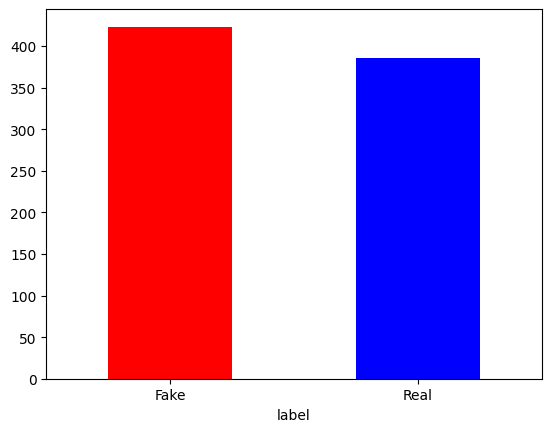

In [24]:
#average word count of articles per label
df_news.groupby(['label'])['text'].apply(lambda x: x.str.split().str.len().mean()).plot(kind='bar', color=['red', 'blue']).set_xticklabels(['Fake', 'Real'], rotation=0)

<Axes: xlabel='subject'>

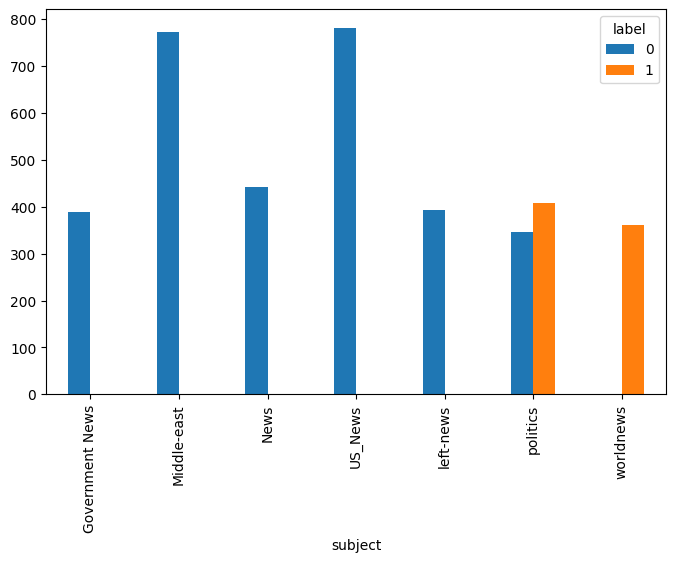

In [25]:
#average word count of articles per subject per label
df_news.groupby(['subject', 'label'])['text'].apply(lambda x: x.str.split().str.len().mean()).unstack().plot(kind='bar', figsize=(8, 5))

# Correlation

<Axes: xlabel='date'>

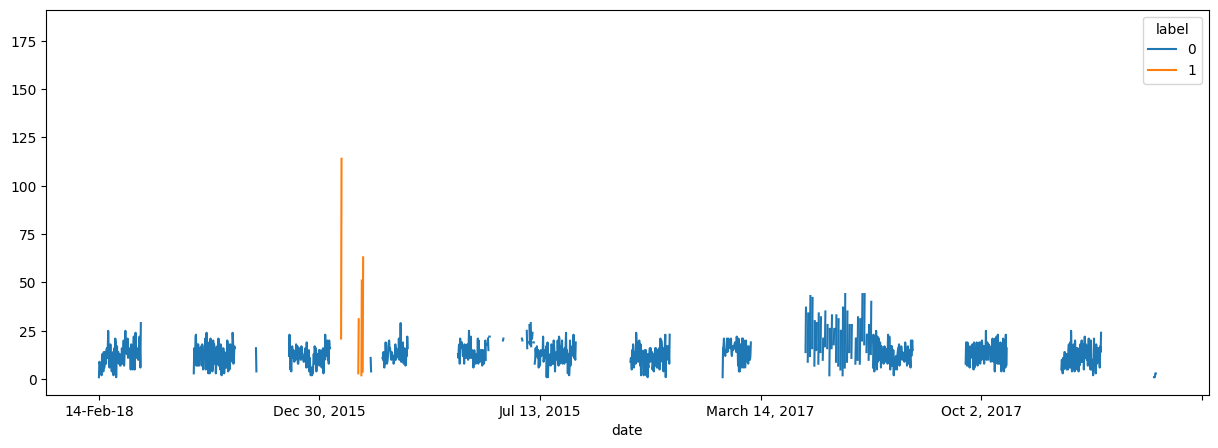

In [26]:
#correlation between date and label
df_news.groupby(['date', 'label']).size().unstack().plot(kind='line', figsize=(15, 5))

[Text(0, 0, 'No'), Text(1, 0, 'Yes')]

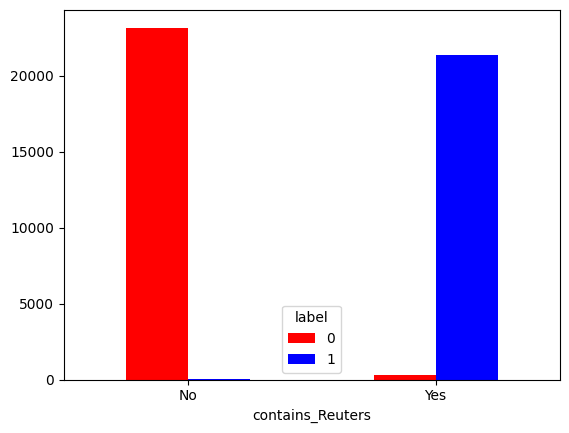

In [27]:
#add column 'contains_Reuters' that will be 1 if the article contains the word 'Reuters' and 0 otherwise
df_news['contains_Reuters'] = df_news['text'].apply(lambda x: 1 if 'Reuters' in x else 0)

#correlation between label and 'contains_Reuters'
df_news.groupby(['contains_Reuters', 'label']).size().unstack().plot(kind='bar', color=['red', 'blue']).set_xticklabels(['No', 'Yes'], rotation=0)

- The plot above shows the correlation between the authenticity of the news and whether the news agency Reuters appears as a source or not, which we noticed while taking a first glance at the data.
- This is self-explanatory, since Reuters is a reliable source of information.
- There are a few outliers where the news are true even if reuters doesn't appear in the text or reuters is cited as the source, but the text overall probably contains half true information.

# 4. Prepare the data

- function for transforming text data: TF-IDF (Term Frequency - Inverse Document Frequency) 
- splitting the data including training, testing and validation sets
- using only title and text on the X variable
- labels will be the label column (0 or 1, namely fake or real)

In [42]:
from sklearn.feature_extraction.text import TfidfVectorizer

def transform_with_tfidf(X_train, X_val, X_test, max_df=0.6):
    """
    Transform input data using TfidfVectorizer.

    Parameters:
    - X_train: Training data
    - X_val: Validation data
    - X_test: Test data
    - max_df: Maximum document frequency for TfidfVectorizer

    Returns:
    - X_train_tfidf: Transformed training data
    - X_val_tfidf: Transformed validation data
    - X_test_tfidf: Transformed test data
    """

    tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=max_df)

    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

    X_val_tfidf = tfidf_vectorizer.transform(X_val)
    X_test_tfidf = tfidf_vectorizer.transform(X_test)

    return X_train_tfidf, X_val_tfidf, X_test_tfidf

In [31]:
X = df_news['title'] + ' ' + df_news['text']
y = df_news['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# 5. Short-list promising models
- we are sorting them by the method we are using to transform the text:
   - for TF-IDF: MultinomialNaiveBayes, K-Nearest-Neighbors as classifiers, CNN and RNN as neural networks
   - for Word2Vec: A simple neural network with default parameters (which we can then fine tune if we choose this model)

## I. TF-IDF

In [32]:
X_train_tfidf, X_val_tfidf, X_test_tfidf = transform_with_tfidf(X_train, X_val, X_test, max_df=0.6)

### a) Multinomial naive bayes 

In [37]:
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

y_pred = clf.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

y_val_pred = clf.predict(X_val_tfidf)

val_accuracy = accuracy_score(y_val, y_val_pred)
print(f'Validation Accuracy: {val_accuracy:.2f}')

print(classification_report(y_test, y_pred))

Accuracy: 0.94
Validation Accuracy: 0.93
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2372
           1       0.94      0.93      0.93      2118

    accuracy                           0.94      4490
   macro avg       0.94      0.94      0.94      4490
weighted avg       0.94      0.94      0.94      4490



### b) KNN with an arbitrary number of neighbors

In [43]:
knn_classifier = KNeighborsClassifier(n_neighbors=5) 
knn_classifier.fit(X_train_tfidf, y_train)

y_pred = knn_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print(f'Test Accuracy: {accuracy:.2f}')

print(classification_report(y_test, y_pred))

Test Accuracy: 0.89
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      2372
           1       0.84      0.95      0.89      2118

    accuracy                           0.89      4490
   macro avg       0.89      0.89      0.89      4490
weighted avg       0.89      0.89      0.89      4490



### c) Convolutional Neural Network

### d) Recursive Neural Network

### f) Testing out the most promising one from above with new data (some random article texts)

## II) Using WordEmbeddings for text representation (Word2Vec) and a simple neural network

In [ ]:
X = df_news['title'] + ' ' + df_news['text']
y = df_news['label']

# Convert labels to numerical values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Tokenize the text data
max_words = 10000  # Adjust based on the size of your vocabulary
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to ensure consistent length for input to neural network
max_sequence_length = 1000  # Adjust based on your dataset
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

# Train Word2Vec model
tokenized_sentences = [text.split() for text in X_train]
word2vec_model = Word2Vec(sentences=tokenized_sentences, vector_size=100, window=5, min_count=1, workers=4)

# Create an embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        try:
            embedding_vector = word2vec_model.wv[word]
            embedding_matrix[i] = embedding_vector
        except KeyError:
            # Word not in Word2Vec model vocabulary
            pass

# Build a simple neural network model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length, weights=[embedding_matrix], trainable=False))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train_padded, y_train, epochs=5, batch_size=32, validation_split=0.2)

In [ ]:
# Evaluate the model on the test set
y_pred = model.predict(X_test_padded)
y_pred = y_pred.flatten()

# Convert predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(((y_pred > 0.5).astype(int)))
print(y_pred_labels)
print(y_test)
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred_labels)
print(f'Test Accuracy: {accuracy:.2f}')

# Print classification report for the test set
print(classification_report(y_test, y_pred_labels))

# 6. Choosing a model and fine-tuning it